In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
from IPython import display as ICD
from nba_api.stats.endpoints import leaguedashplayerstats, leaguedashteamclutch, leaguegamelog, boxscoreplayertrackv2, playercareerstats, teamplayerdashboard, leaguestandings
from nba_api.stats.static import players, teams

import numpy as np
import statsmodels.api as sm

import time

import warnings
warnings.filterwarnings("ignore")

# Bias Boosted Monte Carlo Simulation

In [4]:
sum(get_rand_sample(all_playoff_games, 'PrevPTS', 139, 'PTS', 1000))/1000

NameError: name 'get_rand_sample' is not defined

In [ ]:
temp = pd.Series()
for x in range (100,180,1):
    val = sum(get_rand_sample(all_playoff_games, 'PrevPTS', x, 'PTS', 1000))/1000
    temp.loc[x] = val
temp.to_frame().reset_index().plot.scatter(x='index',y=0)
plt.show()

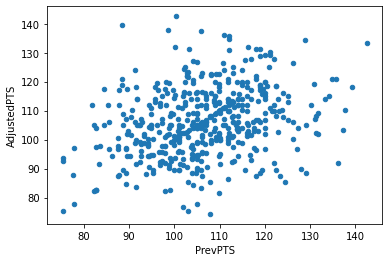

In [224]:
all_playoff_games.plot.scatter(x='PrevPTS', y='AdjustedPTS')

In [39]:
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
def get_weight(x, col_value, range_val):
    return 1/math.sqrt(00.1+abs((x-col_value)/range_val))
def get_rand_sample(df, col_name, col_value, sample_col_name, N, range_val):
    weights = df[col_name].apply(lambda x: get_weight(x,col_value, range_val))
    to_return = random.choices(population=list(df[sample_col_name]), 
                               weights=weights,
                               k=N)
    return to_return

In [40]:
all_playoff_games = pd.read_csv('first_round_games.csv')
offense_cols = ['PlayoffMins','Age','SeriesGP','MissingMins','PointsPG','OppPointsPGOpponent','PrevPTS']
defense_cols = ['PlayoffMins','Age','SeriesGP','MissingMins','OppPointsPG','PointsPGOpponent','PrevOPTS']

In [41]:
def get_predictions(playoff_games, cols, predictor, N, model = None):
    predictions = all_playoff_games[['GameID','GameDate', 'MATCHUP'] + [predictor]]
    col_sum = []
    for x in cols:
        col_sum.append(x + "Sum")
    for col in cols:
        predictions[col] = playoff_games.apply(lambda x: get_rand_sample(playoff_games,col,x[col],predictor,N,playoff_games[col].max()-playoff_games[col].min()), axis = 1)
    for col in range(len(cols)):
        predictions[col_sum[col]] = predictions[cols[col]].apply(lambda x: sum(x)/N)
    X = predictions[col_sum]
    y = predictions[predictor]
    
    if(not model):
        model = LinearRegression().fit(X,y)
    
    coefs = pd.Series(model.coef_, index = col_sum).abs()
    predictions[predictor + 'Combined'] = predictions[cols].apply(lambda x: (np.array(x.values.tolist()) * coefs.values[:, None]).sum(axis=0)/coefs.sum(), axis = 1)
    predictions[predictor + 'LinearRegression'] = model.predict(X)
    ICD.display(predictions)
    return predictions[[predictor + 'Combined', predictor + 'LinearRegression']], model
        

In [50]:
pts_df, pts_model = get_predictions(all_playoff_games, offense_cols, 'AdjustedPTS', 1000)
opts_df, opts_model = get_predictions(all_playoff_games, defense_cols, 'AdjustedOPTS', 1000)
final = pd.concat([all_playoff_games, pts_df, opts_df], axis = 1)
final['WinProba'] = final.apply(lambda x: np.count_nonzero(x['AdjustedPTSCombined'] > x['AdjustedOPTSCombined'])/1000, axis = 1)
final['WinProbaScaled'] = final.apply(lambda x: x['WinProba']* 1/final[final['GameID'] == x['GameID']]['WinProba'].sum(), axis = 1)
final['WinProba2x'] = final.apply(lambda x: max(0,min(1,2*x['WinProbaScaled']-0.5)), axis = 1)
import scipy.stats
norm_dist = scipy.stats.norm(0, 10)
final['WinProbaNorm'] = final.apply(lambda x: norm_dist.cdf(x['AdjustedPTSLinearRegression'] - x['AdjustedOPTSLinearRegression']), axis = 1)



,GameID,GameDate,MATCHUP,AdjustedPTS,PlayoffMins,Age,SeriesGP,MissingMins,PointsPG,OppPointsPGOpponent,PrevPTS,PlayoffMinsSum,AgeSum,SeriesGPSum,MissingMinsSum,PointsPGSum,OppPointsPGOpponentSum,PrevPTSSum,AdjustedPTSCombined,AdjustedPTSLinearRegression
0,41600151,4/15/17,SAS vs. MEM,110.050671,"[109.1648115, 103.89623940000001, 92.32343892,...","[115.0079081, 107.10509809999999, 114.01646059...","[105.0453847, 87.75701777, 107.93104479999998,...","[94.81792725, 111.9089128, 98.15330084, 111.96...","[99.86143402, 91.56183771, 98.15330084, 97.836...","[100.87013540000001, 105.2054334, 94.81792725,...","[116.0209453, 104.015528, 95.17895839, 137.342...",105.070033,104.281658,104.401675,105.293526,103.364339,104.348962,105.850448,"[106.7228363463453, 101.13474458595988, 98.054...",106.570876
1,41600151,4/15/17,MEM @ SAS,82.713511,"[97.33960663, 111.9658503, 95.63125272, 109.16...","[98.15330084, 92.32343892, 126.3373375, 87.492...","[104.10198570000001, 100.0980443, 99.89610113,...","[81.70480965, 94.18751091, 113.02501310000001,...","[94.18751091, 98.15330084, 108.9397462, 94.267...","[120.0354611, 116.0209453, 93.2952646, 103.896...","[116.0209453, 116.0209453, 112.08803190000002,...",104.179199,104.569090,104.326912,104.121397,103.287208,103.921067,103.385441,"[103.03649420785794, 106.72683858843119, 105.0...",92.802120
2,41600171,4/15/17,UTA @ LAC,97.844031,"[113.02501310000001, 116.6190807, 100.0980443,...","[99.12621863, 86.25593104, 103.2389767, 98.866...","[101.87883670000001, 116.3738085, 106.07524140...","[94.81792725, 97.84403131, 101.27252, 126.6723...","[111.9658503, 104.10198570000001, 112.08803190...","[97.84403131, 105.8047902, 118.5627321, 111.96...","[106.822144, 99.70066773, 105.0453847, 94.7468...",104.761468,104.635966,104.556625,104.566350,103.495802,103.870132,104.693392,"[105.91163570914118, 105.85213024057279, 106.5...",100.795958
3,41600171,4/15/17,LAC vs. UTA,94.187511,"[97.18256729, 108.0677757, 117.987402, 106.922...","[118.5627321, 104.9049408, 98.15330084, 104.95...","[126.3373375, 109.0592232, 98.15330084, 89.597...","[106.92234350000001, 91.44023653, 91.44023653,...","[94.26709027, 116.0209453, 98.86624442, 105.80...","[104.9571727, 116.0209453, 100.0980443, 99.306...","[97.18256729, 121.06509650000001, 77.67000424,...",104.541174,104.861808,104.699248,104.583151,104.739633,103.729495,103.249205,"[103.29113236148193, 111.58464237201768, 98.73...",99.068275
4,41600111,4/15/17,IND @ CLE,108.939746,"[111.9089128, 97.18256729, 119.9651455, 91.561...","[104.9049408, 112.7317781, 116.3738085, 100.09...","[115.6472551, 105.2054334, 94.38992158, 109.81...","[117.5909064, 129.2039265, 112.7317781, 98.866...","[111.9658503, 87.4924227, 127.3091631, 104.101...","[101.7353752, 109.1383468, 119.03038899999999,...","[108.0677757, 118.97063030000001, 94.38992158,...",104.603174,105.435290,104.229611,104.400786,103.901948,104.791886,104.576108,"[110.0982115655682, 105.92842090865906, 112.53...",103.222026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,41800156,4/25/19,SAS vs. DEN,117.987402,"[91.56183771, 112.7317781, 112.08803190000002,...","[105.8047902, 137.3427566, 115.0079081, 91.791...","[101.06987, 93.71696086, 108.1551185, 108.0677...","[118.97063030000001, 116.00065570000001, 82.29...","[98.15330084, 97.83638771, 109.1648115, 102.11...","[102.752729, 100.0980443, 92.57919146, 91.2131...","[112.08803190000002, 104.015528, 89.4079619, 9...",104.742884,105.011286,103.979859,104.887491,104.929570,104.835288,103.332507,"[102.44139208171092, 106.98910117745018, 102.0...",102.393623
256,41800146,4/26/19,GSW @ LAC,131.238634,"[91.44023653, 97.18256729, 114.960974, 119.030...","[92.80052454, 118.5627321, 118.97063030000001,...","[116.00065570000001, 117.987402, 101.9558146, ...","[105.8047902, 100.0980443, 101.7353752, 89.597...","[95.63125272, 98.15330084, 104.10198570000001,...","[101.1276433, 128.8029138, 97.84403131, 129.20...","[117.987402, 98.85273266, 118.9706303000

,GameID,GameDate,MATCHUP,AdjustedOPTS,PlayoffMins,Age,SeriesGP,MissingMins,OppPointsPG,PointsPGOpponent,PrevOPTS,PlayoffMinsSum,AgeSum,SeriesGPSum,MissingMinsSum,OppPointsPGSum,PointsPGOpponentSum,PrevOPTSSum,AdjustedOPTSCombined,AdjustedOPTSLinearRegression
0,41600151,4/15/17,SAS vs. MEM,82.713511,"[97.18256729, 111.7599524, 105.09343319999999,...","[107.0763282, 88.56767729, 104.015528, 77.7460...","[128.8029138, 102.752729, 109.816301, 112.7317...","[106.1886618, 99.12621863, 117.987402, 105.093...","[91.21316846, 86.25593104, 111.9658503, 112.73...","[91.56183771, 109.1648115, 109.0592232, 110.05...","[97.18256729, 95.17895839, 116.990803, 93.7169...",104.074790,104.359830,105.005869,104.641203,104.083046,103.879350,103.287400,"[101.04530675874717, 99.60251075648128, 111.83...",96.543734
1,41600151,4/15/17,MEM @ SAS,110.050671,"[98.86624442, 87.4924227, 107.93104479999998, ...","[99.12621863, 95.23891594, 108.9397462, 98.153...","[94.18751091, 101.87883670000001, 109.87420520...","[108.0677757, 111.9089128, 105.2054334, 94.187...","[98.85273266, 91.21316846, 129.1137733, 112.03...","[110.0506706, 87.75701777, 116.3738085, 88.567...","[105.0453847, 120.0354611, 101.1276433, 100.92...",104.851903,104.220668,104.265515,103.850491,104.271344,104.202419,104.914339,"[103.7453681010309, 102.09510970354822, 109.80...",102.251321
2,41600171,4/15/17,UTA @ LAC,94.187511,"[82.713511, 83.57440973, 106.1886618, 99.86143...","[99.30606333, 109.94844760000001, 137.3427566,...","[108.0677757, 77.74605383, 109.816301, 92.3234...","[97.84403131, 134.2906953, 101.87883670000001,...","[100.71802149999999, 98.85273266, 118.5627321,...","[108.0677757, 103.2389767, 112.0335656, 105.09...","[97.66596022, 105.0453847, 120.0354611, 120.03...",104.626547,104.961417,104.707150,103.896850,103.706600,104.052898,103.512265,"[100.4555466463296, 103.54459455094099, 115.28...",97.194621
3,41600171,4/15/17,LAC vs. UTA,97.844031,"[92.32343892, 100.92595779999999, 119.9651455,...","[91.56183771, 104.9571727, 113.2842384, 95.178...","[121.06509650000001, 106.1886618, 109.816301, ...","[108.85685149999999, 119.95385870000001, 93.71...","[91.79182319, 96.35637828, 122.5529488, 118.97...","[91.44023653, 91.44023653, 91.56183771, 92.687...","[104.9049408, 114.960974, 106.1886618, 115.647...",104.567551,104.365979,104.755985,103.759499,103.695751,103.311304,104.626900,"[100.67830954580172, 105.5464966819253, 104.88...",97.974834
4,41600111,4/15/17,IND @ CLE,108.067776,"[95.17895839, 100.0980443, 96.35637828, 111.96...","[104.9049408, 82.29014111, 101.9558146, 111.96...","[91.56183771, 97.83638771, 105.0453847, 125.13...","[90.22172097, 102.0416957, 103.11053829999999,...","[120.0354611, 106.07524140000001, 120.0354611,...","[89.4079619, 111.224525, 108.9397462, 96.21074...","[119.95385870000001, 92.20461594, 120.0354611,...",104.747086,104.559635,104.164859,104.832608,104.310864,105.161867,104.628452,"[102.59964904919899, 99.22696115450992, 110.00...",106.370804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,41800156,4/25/19,SAS vs. DEN,104.787436,"[125.1345115, 101.06987, 108.8444754, 94.81792...","[101.06987, 106.07524140000001, 99.30606333, 9...","[99.12621863, 129.1137733, 113.0712602, 115.64...","[99.89610113, 98.85273266, 104.9571727, 114.31...","[105.8047902, 108.1551185, 117.987402, 115.999...","[101.27252, 105.2054334, 106.07524140000001, 1...","[106.92234350000001, 118.97063030000001, 88.56...",103.948285,104.919536,104.758822,104.975342,104.524462,105.115094,104.778513,"[104.64259021510466, 110.78226057867903, 102.5...",107.892749
256,41800146,4/26/19,GSW @ LAC,108.155119,"[94.74681757, 108.9397462, 88.23882601, 77.746...","[99.12621863, 91.56183771, 98.85273266, 109.05...","[98.85273266, 109.87420520000002, 88.56767729,...","[86.25593104, 109.1383468, 117.987402, 94.2670...","[95.23891594, 94.74681757, 127.3091631, 126.33...","[120.0354611, 88.56767729, 116.00065570000001,...","[109.87420520000002, 97.84403131, 94

In [43]:
### print('AdjustedPTS', final['AdjustedPTS'].var())
print('AdjustedOPTS', final['AdjustedOPTS'].var())

print('AdjustedPTSLinearRegression', final['AdjustedPTSLinearRegression'].var())
print('AdjustedOPTSLinearRegression', final['AdjustedOPTSLinearRegression'].var())



AdjustedOPTS 137.40113922557896
AdjustedPTSLinearRegression 44.65869481448544
AdjustedOPTSLinearRegression 44.03287474955176


In [33]:
print('AdjustedPTS', final['AdjustedPTS'].var())
print('AdjustedOPTS', final['AdjustedOPTS'].var())

print('AdjustedPTSLinearRegression', final['AdjustedPTSLinearRegression'].var())
print('AdjustedOPTSLinearRegression', final['AdjustedOPTSLinearRegression'].var())


AdjustedPTS 143.09778282043828
AdjustedOPTS 143.09778282043828
AdjustedPTSLinearRegression 45.08579884871418
AdjustedOPTSLinearRegression 44.896808261654016


In [44]:
pts_var = (final['AdjustedPTS'] - final['AdjustedPTSLinearRegression']).var()
pts_mean = (final['AdjustedPTS'] - final['AdjustedPTSLinearRegression']).mean()
opts_var = (final['AdjustedOPTS'] - final['AdjustedOPTSLinearRegression']).var()
opts_mean = (final['AdjustedOPTS'] - final['AdjustedOPTSLinearRegression']).mean()
print("PTS Variance:  ", pts_var)
print("PTS Mean:      ", pts_mean)
print("OPTS Variance: ", opts_var)
print("OPTS Mean:     ", opts_mean)

print("Comb. Variance:", (pts_var + opts_var)/2)
print("Comb. Mean:    ", (pts_mean + opts_mean)/2)

PTS Variance:   92.74244441109366
PTS Mean:       1.8255482595682575e-14
OPTS Variance:  93.36826447602725
OPTS Mean:      -1.9425145253010738e-13
Comb. Variance: 93.05535444356045
Comb. Mean:     -8.79979849672124e-14


In [10]:
import pickle
pickle.dump( pts_model, open( "pts_model", "wb" ) )
pickle.dump( opts_model, open( "opts_model", "wb" ) )

In [51]:
def get_accuracy(left, right, df):
    curr_df = df[df['WinProbaNorm'].between(left,right, inclusive=True)]
    curr_df = (curr_df['AdjustedPTS'] > curr_df['AdjustedOPTS']).value_counts()
    if(True in curr_df):
        return curr_df[True]/curr_df.sum()
    if(False in curr_df):
        return 0
    return 1
accuracy_df = pd.DataFrame(columns=['left','right'])
for x in range(0,20):
    accuracy_df.loc[len(accuracy_df)] = [x/20, (x+1)/20]
accuracy_df['Accuracy'] = accuracy_df.apply(lambda x: get_accuracy(x['left'],x['right'],final), axis = 1)
accuracy_df

,left,right,Accuracy
0,0.00,0.05,0.000000
1,0.05,0.10,0.200000
2,0.10,0.15,0.166667
3,0.15,0.20,0.375000
4,0.20,0.25,0.416667
5,0.25,0.30,0.263158
6,0.30,0.35,0.454545
7,0.35,0.40,0.400000
8,0.40,0.45,0.333333
9,0.45,0.50,0.200000


In [241]:
all_playoff_games.to_csv('all_playoff_games.csv', index = False)

In [ ]:
player_dfs = []
grouped = leaguedashplayerstats.LeagueDashPlayerStats(season='2019-20', season_type_all_star='Regular Season').get_data_frames()[0].groupby('TEAM_ID')

for group in list(grouped.groups):
    curr_group = grouped.get_group(group)
    player_dfs.append(curr_group.sort_values('MIN', ascending=False).head(8))
player_df = pd.concat(player_dfs)


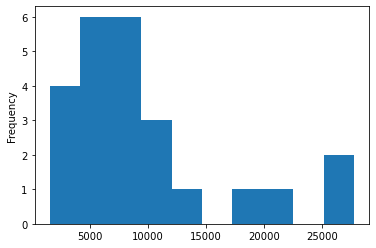

In [94]:
all_playoff_games.drop_duplicates('TeamID')['PlayoffMins'].plot.hist()